<center>
<h1 style="font-weight:bold;color:#a64d79">Student mental health : </br>Stress, factors and coping strategies</h1>
<p>Hadoop Project | Group 11 - 3IABD2</p>
</center>

<h2 style="font-weight:bold;color:#c27ba0">Objectives</h2>

<p>This project aims to identify the causes of stress and coping strategies through the analysis of large-scale data, using Big Data tools and machine learning techniques.</p>

<hr style="border: none; height: 0.5px; background-color: #aaa;" />

In [365]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, stddev, min, max, col, when, count
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<h2 style="font-weight:bold;color:#c27ba0">Dataframe creation</h2>

In [366]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("SMHAnalysis") \
    .getOrCreate()

In [367]:
# Read CSV files from HDFS and create DataFrames
df_sample = spark.read.option("header", True) \
    .option("inferSchema", True) \
    .csv("hdfs://localhost:9000/data_input/dataset-1.csv")

df_esgi = spark.read.option("header", True) \
    .option("inferSchema", True) \
    .csv("hdfs://localhost:9000/data_input/dataset-2.csv")

# Cleaning column names
df_sample = df_sample.toDF(*[c.strip() for c in df_sample.columns])
df_esgi = df_esgi.toDF(*[c.strip() for c in df_esgi.columns])


df_all = df_sample.unionByName(df_esgi)

# Display the first 5 rows of sample dataset
print("------------------------------------------------------------------------")
print("Preview of the first few rows :")
print("------------------------------------------------------------------------\n")
df_all.show(5)

------------------------------------------------------------------------
Preview of the first few rows :
------------------------------------------------------------------------

+-----------+---+------+--------------------------+--------------------+----------------------------------+--------------------------------+----------------------------------+--------------+----------------+-------------+-------------------+-------------------+---------------------+------------+------------------------+---------------------+----------------------------+-----------------+-------------+
| Student ID|Age|Gender|Academic Performance (GPA)|Study Hours Per Week|Social Media Usage (Hours per day)|Sleep Duration (Hours per night)|Physical Exercise (Hours per week)|Family Support|Financial Stress|Peer Pressure|Relationship Stress|Mental Stress Level|Counseling Attendance|Diet Quality|Stress Coping Mechanisms|Cognitive Distortions|Family Mental Health History|Medical Condition|Substance Use|
+----------

<h2 style="font-weight:bold;color:#c27ba0">Preprocessing and Exploratory Data Analysis</h2>

In [368]:
# Dimensions of the dataset
print("------------------------------------------------------------------------")
print("Dimensions of dataframes :")
print("------------------------------------------------------------------------\n")

print("Rows :")
print(f"- Sample dataset : {df_sample.count()} rows")
print(f"- ESGI dataset : {df_esgi.count()} rows")
print(f"- TOTAL ROWS : {df_all.count()} rows")

print(f"\nColumns : ")
print(f"- TOTAL COLUMNS : {len(df_all.columns)} columns")

------------------------------------------------------------------------
Dimensions of dataframes :
------------------------------------------------------------------------

Rows :
- Sample dataset : 760 rows
- ESGI dataset : 174 rows
- TOTAL ROWS : 934 rows

Columns : 
- TOTAL COLUMNS : 20 columns


In [369]:
# Columns details
print("-----------------------------------------------------------------------------------")
print("Columns details :")
print("-----------------------------------------------------------------------------------\n")

print(f"{'NAME':<40} {'TYPE':<10} {'NULL VALUES':<15} {'NON-NULL VALUES':<10}")

for column, dtype in df_all.dtypes:
    null_values = df_all.filter(col(column).isNull()).count()
    non_null_values = df_all.filter(col(column).isNotNull()).count()
    print(f"{column:<40} {dtype:15} {null_values:<15} {non_null_values:<10}")

-----------------------------------------------------------------------------------
Columns details :
-----------------------------------------------------------------------------------

NAME                                     TYPE       NULL VALUES     NON-NULL VALUES
Student ID                               string          0               934       
Age                                      int             0               934       
Gender                                   string          0               934       
Academic Performance (GPA)               int             0               934       
Study Hours Per Week                     int             0               934       
Social Media Usage (Hours per day)       int             0               934       
Sleep Duration (Hours per night)         int             0               934       
Physical Exercise (Hours per week)       int             0               934       
Family Support                           int             

In [370]:
# Delete Student ID column
df_sample = df_sample.drop("Student Id")
df_esgi = df_esgi.drop("Student Id")
df_all = df_all.drop("Student Id")

In [372]:
# Converting string columns to numeric types : column with YES/NO values
def yes_no_to_int(df, columns):
    for column in columns:
        if type(df.schema[column].dataType) != IntegerType:
            df = df.withColumn(
                column,
                when(col(column) == "Yes", 1)
                .when(col(column) == "No", 0)
                .cast(IntegerType())
            )
    return df

# Counselling, Family Mental Health History, Mental Condition | YES(1), NO(0)
string_columns = ["Counseling Attendance", "Family Mental Health History", "Medical Condition"]
df_sample = yes_no_to_int(df_sample, string_columns)
df_esgi = yes_no_to_int(df_esgi, string_columns)
df_all = yes_no_to_int(df_all, string_columns)

In [373]:
# Converting string columns to numeric types : columns with other values
def other_value_to_int(df, columns):
    for column in columns:
        if type(df.schema[column].dataType) != IntegerType:
            if column == "Gender":
                df = df.withColumn(
                    column,
                    when(col(column) == "Male", 1)
                    .when(col(column) == "Female", 0)
                    .otherwise(2)
                    .cast(IntegerType())
                )

            if column == "Stress Coping Mechanisms":
                coping_values = [row[0] for row in df.select("Stress Coping Mechanisms").distinct().collect()]
                coping_dict = {mechanism: i for i, mechanism in enumerate(coping_values)}
                
                expr = None
                for mechanism, value in coping_dict.items():
                    expr = when(col(column) == mechanism, value)if expr is None else expr.when(col(column) == mechanism, value)
                expr = expr.cast(IntegerType())
                df = df.withColumn(column, expr)

    return df

# Gender | MALE(0), FEMALE(1), OTHER(2)
# Stress Coping Mechanisms | SPENDING TIME ALONE(0), ...

string_columns = ["Gender", "Stress Coping Mechanisms"]

df_sample = other_value_to_int(df_sample, string_columns)
df_esgi = other_value_to_int(df_esgi, string_columns)
df_all = other_value_to_int(df_all, string_columns)

-----------------------------------------------------------------------------------
Mental Stress Level :
-----------------------------------------------------------------------------------



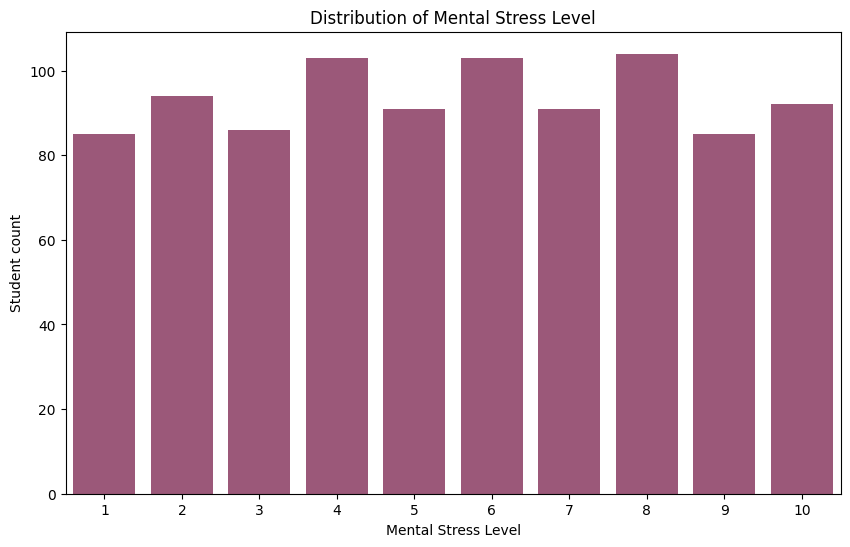

In [374]:
# Mental Stress Level details
print("-----------------------------------------------------------------------------------")
print("Mental Stress Level :")
print("-----------------------------------------------------------------------------------\n")


# Distribution of Mental Stress Level
stress_level_distrib = df_all.groupBy("Mental Stress Level").count().sort("Mental Stress Level").collect()

levels = [row["Mental Stress Level"] for row in stress_level_distrib]
counts = [row["count"] for row in stress_level_distrib]

plt.figure(figsize=(10,6))
sns.barplot(x=levels, y=counts, color="#a64d79")
plt.xlabel("Mental Stress Level")
plt.ylabel("Student count")
plt.title("Distribution of Mental Stress Level")
plt.show()

-----------------------------------------------------------------------------------
Gender :
-----------------------------------------------------------------------------------



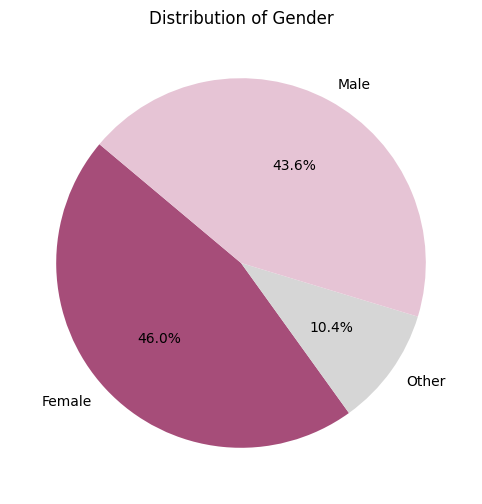

In [375]:
# Distribution of Gender

print("-----------------------------------------------------------------------------------")
print("Gender :")
print("-----------------------------------------------------------------------------------\n")

# Distribution of Gender
gender_distrib = df_all.groupBy("Gender").count().collect()
    
genders = [row["Gender"] for row in gender_distrib]
labels = ["Male" if gender == 0 else "Female" if gender == 1 else "Other" for gender in genders]
counts = [row["count"] for row in gender_distrib]

plt.figure(figsize=(10,6))
plt.pie(
    counts, 
    labels=labels, 
    autopct='%1.1f%%',
    startangle=140,
    colors=["#a64d79", "#d6d6d6", "#e6c4d5"]
)
plt.title("Distribution of Gender")
plt.show()

In [376]:
# Statistics for each column
print("-----------------------------------------------------------------------------------")
print("Statistics :")
print("-----------------------------------------------------------------------------------")

numeric_columns = ["Study Hours Per Week", "Social Media Usage (Hours per day)", "Sleep Duration (Hours per night)", "Physical Exercise (Hours per week)", "Age", "Academic Performance (GPA)", "Family Support", "Financial Stress", "Peer Pressure", "Relationship Stress", "Mental Stress Level", "Diet Quality", "Cognitive Distortions", "Substance Use"]
bool_columns = ["Counseling Attendance", "Family Mental Health History", "Medical Condition"]

def compute_statistics(df, columns, mode):

    # Numeric columns statistics
    if mode == "numeric":
        print(f"\n{"NAME":<40} {"MIN":<10} {"MAX":<10} {"AVG":<10}")
        for column in columns:
            stats = df.select(
                min(col(column)).alias('min'),
                max(col(column)).alias('max'),
                avg(col(column)).alias('avg')
            ).collect()[0]
            print(f"{column:<40} {stats['min']:<10} {stats['max']:<10} {stats['avg']:<10.2f}")

    # Boolean columns statistics
    elif mode == "bool":
        print(f"\n{"NAME":<40} {"TRUE":<10} {"FALSE":<10}")
        for column in columns:
            stats = df.select(
                count(when(col(column) == 1, True)).alias('count_yes'),
                count(when(col(column) == 0, True)).alias('count_no')
            ).collect()[0]
            print(f"{column:<40} {stats['count_yes']:<10} {stats['count_no']:<10}")

compute_statistics(df_all, numeric_columns, "numeric")
compute_statistics(df_all, bool_columns, "bool")

-----------------------------------------------------------------------------------
Statistics :
-----------------------------------------------------------------------------------

NAME                                     MIN        MAX        AVG       
Study Hours Per Week                     0          60         25.19     
Social Media Usage (Hours per day)       0          20         4.17      
Sleep Duration (Hours per night)         0          20         8.03      
Physical Exercise (Hours per week)       0          15         4.74      
Age                                      17         32         23.94     
Academic Performance (GPA)               0          4          2.03      
Family Support                           1          5          3.01      
Financial Stress                         1          5          3.03      
Peer Pressure                            1          5          2.95      
Relationship Stress                      1          5          2.92      
Ment

-----------------------------------------------------------------------------------
Correlation analysis:
-----------------------------------------------------------------------------------

              Sleep Duration ↔ Mental Stress Level : Correlation coefficient = 0.03
                      Gender ↔ Mental Stress Level : Correlation coefficient = 0.04
          Exercise Frequency ↔ Mental Stress Level : Correlation coefficient = -0.09
              Family Support ↔ Mental Stress Level : Correlation coefficient = -0.00


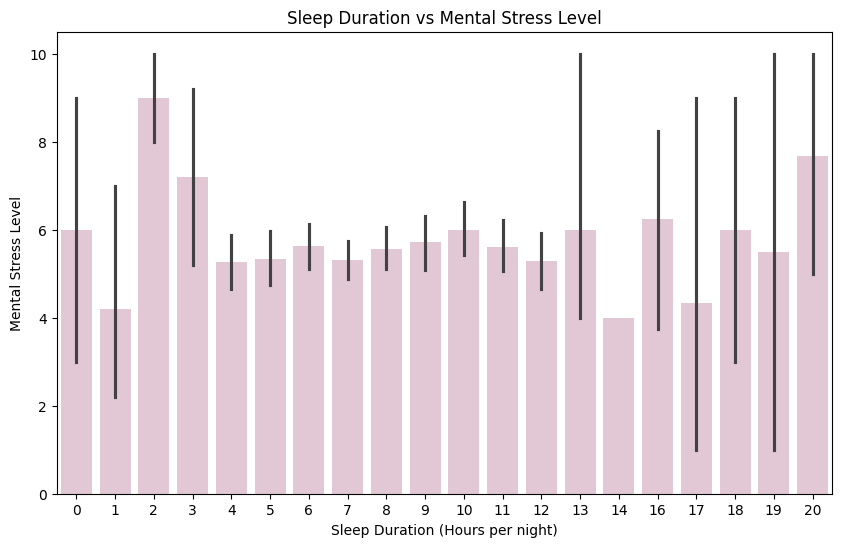

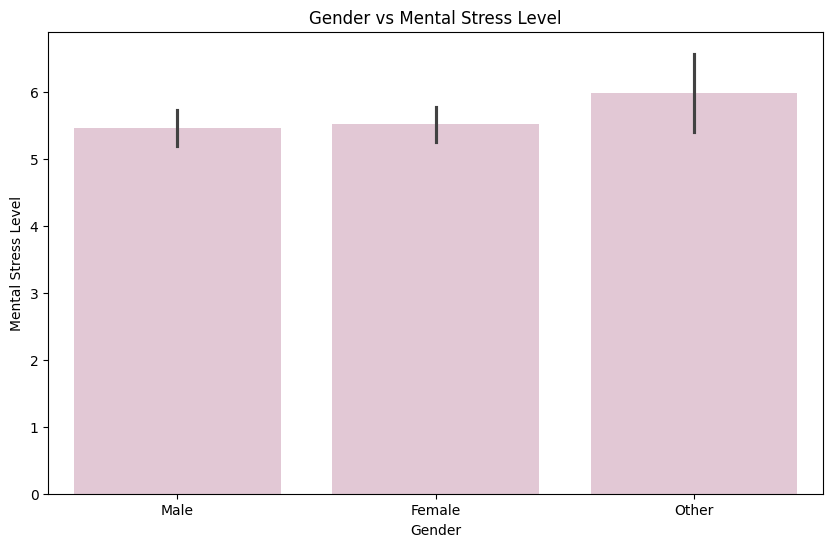

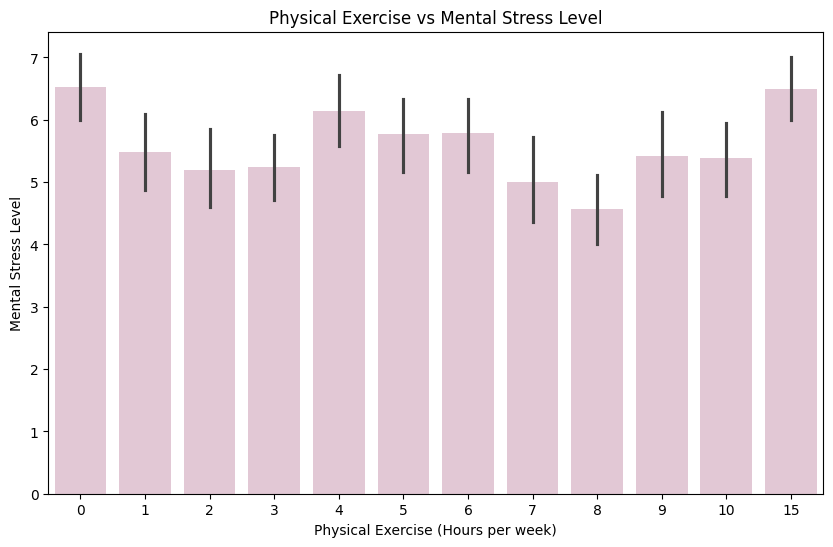

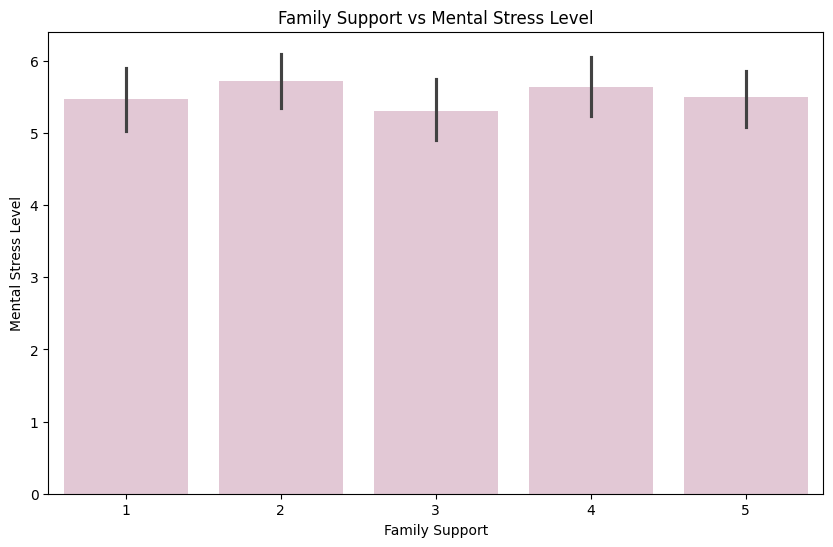

In [377]:
# Correlation analysis
print("-----------------------------------------------------------------------------------")
print("Correlation analysis:")
print("-----------------------------------------------------------------------------------\n")


# Correlation between Sleep Duration (Hours per night) and Mental Stress Level
corr_value = df_all.stat.corr("Sleep Duration (Hours per night)", "Mental Stress Level")
print(f"{"Sleep Duration ↔":>30} Mental Stress Level : Correlation coefficient = {corr_value:.2f}")

sleep_hours_distrib = df_all.select("Mental Stress Level", "Sleep Duration (Hours per night)").collect()
sleep_hours = [row["Sleep Duration (Hours per night)"] for row in sleep_hours_distrib]
stress_level = [row["Mental Stress Level"] for row in sleep_hours_distrib]

plt.figure(figsize=(10,6))
sns.barplot(x=sleep_hours, y=stress_level, color="#e6c4d5")
plt.xlabel("Sleep Duration (Hours per night)")
plt.ylabel("Mental Stress Level")
plt.title("Sleep Duration vs Mental Stress Level")


# Correlation between Gender and Mental Stress Level
corr_value = df_all.stat.corr("Gender", "Mental Stress Level")
print(f"{"Gender ↔":>30} Mental Stress Level : Correlation coefficient = {corr_value:.2f}")

gender_distrib = df_all.select("Mental Stress Level", "Gender").collect()
genders = [row["Gender"] for row in gender_distrib]
labels = ["Male" if gender == 0 else "Female" if gender == 1 else "Other" for gender in genders]
stress_level = [row["Mental Stress Level"] for row in gender_distrib]

plt.figure(figsize=(10,6))
sns.barplot(x=labels, y=stress_level, color="#e6c4d5")
plt.xlabel("Gender")
plt.ylabel("Mental Stress Level")
plt.title("Gender vs Mental Stress Level")

# Correlation between Exercise Frequency and Mental Stress Level
corr_value = df_all.stat.corr("Physical Exercise (Hours per week)", "Mental Stress Level")
print(f"{"Exercise Frequency ↔":>30} Mental Stress Level : Correlation coefficient = {corr_value:.2f}")

exercise_distrib = df_all.select("Mental Stress Level", "Physical Exercise (Hours per week)").collect()
exercise_freq = [row["Physical Exercise (Hours per week)"] for row in exercise_distrib]
stress_level = [row["Mental Stress Level"] for row in exercise_distrib]

plt.figure(figsize=(10,6))
sns.barplot(x=exercise_freq, y=stress_level, color="#e6c4d5")
plt.xlabel("Physical Exercise (Hours per week)")
plt.ylabel("Mental Stress Level")
plt.title("Physical Exercise vs Mental Stress Level")

# Correlation between Family Support and Mental Stress Level
corr_value = df_all.stat.corr("Family Support", "Mental Stress Level")
print(f"{"Family Support ↔":>30} Mental Stress Level : Correlation coefficient = {corr_value:.2f}")

family_distrib = df_all.select("Mental Stress Level", "Family Support").collect()
family_support = [row["Family Support"] for row in family_distrib]
stress_level = [row["Mental Stress Level"] for row in family_distrib]

plt.figure(figsize=(10,6))
sns.barplot(x=family_support, y=stress_level, color="#e6c4d5")
plt.xlabel("Family Support")
plt.ylabel("Mental Stress Level")
plt.title("Family Support vs Mental Stress Level")

plt.show()

-----------------------------------------------------------------------------------------------------------------------------------------------
Correlation matrix :
-----------------------------------------------------------------------------------------------------------------------------------------------



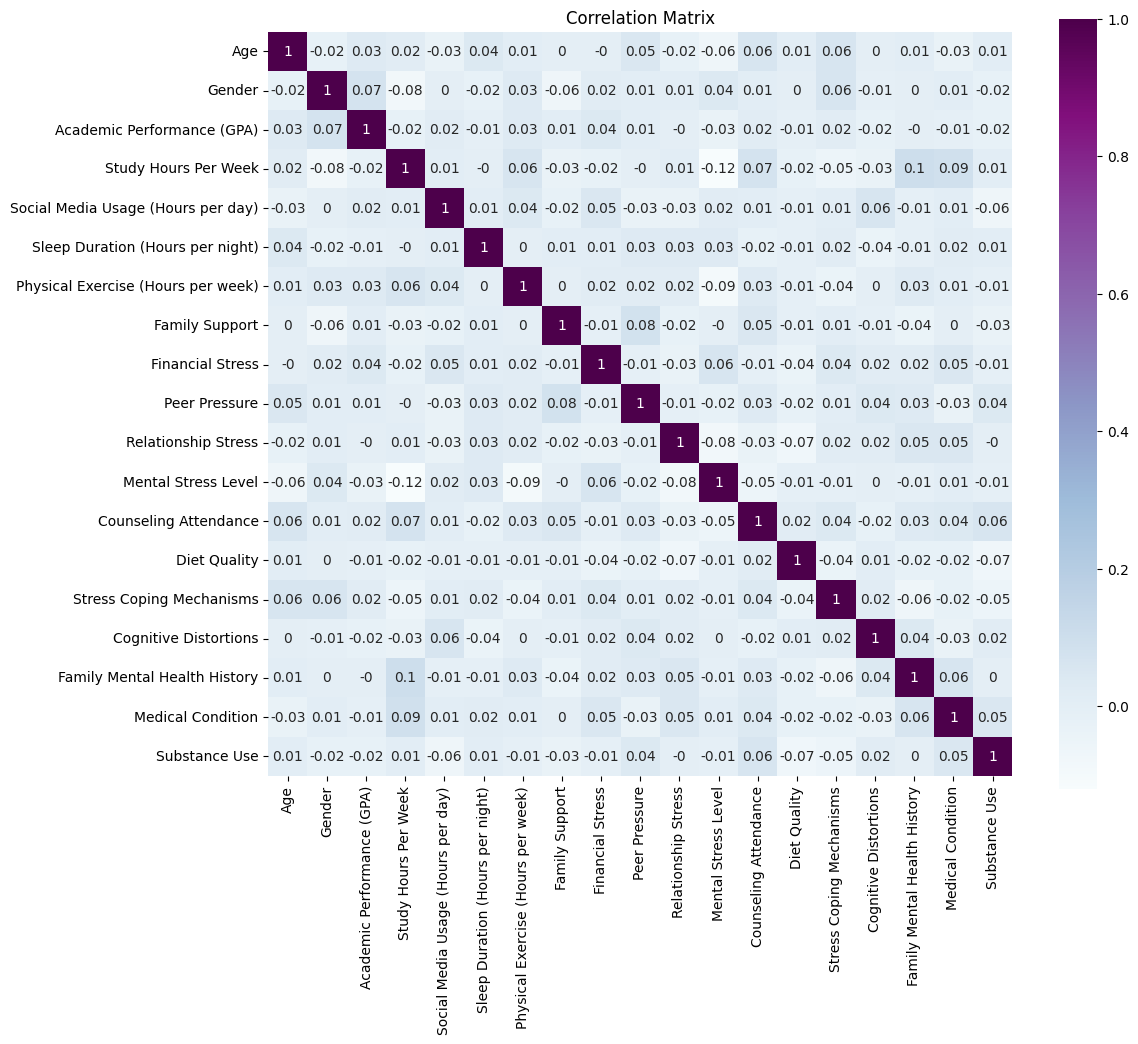

In [378]:
# Correlation
print("-----------------------------------------------------------------------------------------------------------------------------------------------")
print("Correlation matrix :")
print("-----------------------------------------------------------------------------------------------------------------------------------------------\n")

# Correlation matrix
correlation_matrix = np.zeros((len(df_all.columns), len(df_all.columns)))

for i, col1 in enumerate(df_all.columns):
    for j, col2 in enumerate(df_all.columns):
        corr = df_all.stat.corr(col1, col2)
        correlation_matrix[i, j] = f"{corr:.2f}" if corr is not None else "0.00"

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, xticklabels=df_all.columns, yticklabels=df_all.columns, cmap="BuPu", square=True)
plt.title("Correlation Matrix")
plt.show()

-----------------------------------------------------------------------------------------------
Correlation between features and Mental Stress Level :
-----------------------------------------------------------------------------------------------



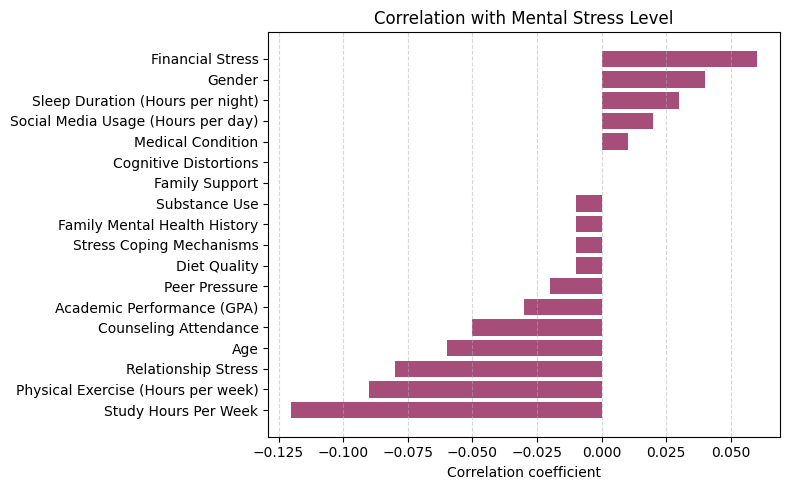

In [379]:
print("-----------------------------------------------------------------------------------------------")
print("Correlation between features and Mental Stress Level :")
print("-----------------------------------------------------------------------------------------------\n")

# Bar chart for Mental Stress Level
target_index = df_all.columns.index("Mental Stress Level")
cor_with_stress = correlation_matrix[target_index]

cor_dict = {
    col: cor_with_stress[i]
    for i, col in enumerate(df_all.columns)
    if i != target_index
}

sorted_corr = dict(sorted(cor_dict.items(), key=lambda item: item[1]))

labels = list(sorted_corr.keys())
values = list(sorted_corr.values())

plt.figure(figsize=(8, 5))
plt.barh(labels, values, color="#a64d79")
plt.title("Correlation with Mental Stress Level")
plt.xlabel("Correlation coefficient")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

<h2 style="font-weight:bold;color:#c27ba0">Clustering</h2>

In [385]:
print("-----------------------------------------------------------------------------------")
print("Clustering :")
print("-----------------------------------------------------------------------------------\n")

# Vectorization of numeric columns
numeric_columns = df_all.columns
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
df_vector = assembler.transform(df_all)

# Standardization of features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

# Best k-mean research 
print("Evaluating silhouette score for different values of k :")
evaluator = ClusteringEvaluator(featuresCol='scaledFeatures', metricName='silhouette', distanceMeasure='squaredEuclidean')
for k in range(2, 11):
    kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=100)
    model = kmeans.fit(df_scaled)
    predictions = model.transform(df_scaled)
    score = evaluator.evaluate(predictions)
    print(f"Silhouette score for k={k}: {score:.4f}")


# Apply KMeans model and predict clusters
kmeans = KMeans(featuresCol="scaledFeatures", k=2, seed=100)
model = kmeans.fit(df_scaled)
df_clusters = model.transform(df_scaled).withColumnRenamed("prediction", "Cluster")

# Display clusters and their centers:
print("\nClusters :")
df_clusters.groupBy("cluster").count().show()

centers = model.clusterCenters()
for cluster, center in enumerate(centers):
    print(f"Cluster {cluster}\nCenter : {center}\n")

-----------------------------------------------------------------------------------
Clustering :
-----------------------------------------------------------------------------------

Evaluating silhouette score for different values of k :
Silhouette score for k=2: 0.1047
Silhouette score for k=3: 0.0736
Silhouette score for k=4: 0.0721
Silhouette score for k=5: 0.0707
Silhouette score for k=6: 0.0761
Silhouette score for k=7: 0.0744
Silhouette score for k=8: 0.0706
Silhouette score for k=9: 0.0725

Clusters :
+-------+-----+
|cluster|count|
+-------+-----+
|      1|  531|
|      0|  403|
+-------+-----+

Cluster 0
Center : [6.21714028 1.0293744  1.47644994 1.46679746 1.61490249 2.80372541
 1.52103024 2.15402895 2.18279286 2.09861447 2.18325048 1.96986052
 0.97944609 2.15153745 1.61638253 2.10020795 1.00388205 2.01796894
 2.16460519]

Cluster 1
Center : [6.27343142 1.01101511 1.50512693 1.2812196  1.60318431 2.76388844
 1.50573769 2.14792912 2.09194658 2.16458934 2.08528103 1.95091995
 0

In [386]:
print("-----------------------------------------------------------------------------------------------------------------------------------------------")
print("Correlation matrix by cluster:")
print("-----------------------------------------------------------------------------------------------------------------------------------------------\n")

# Liste des colonnes numériques à corréler (évite features, scaledFeatures, cluster)
numeric_cols = df_all.columns

# Liste des clusters
cluster_ids = [row["cluster"] for row in df_clusters.select("cluster").distinct().collect()]

for cluster in cluster_ids:
    print(f"\n🧪 Cluster {cluster}")
    
    # Filtrer les lignes du cluster courant
    cluster_df = df_clusters.filter(df_clusters["cluster"] == cluster)

    # Initialiser la matrice de corrélation
    corr_matrix = np.zeros((len(numeric_cols), len(numeric_cols)))

    # Double boucle pour remplir la matrice
    for i, col1 in enumerate(numeric_cols):
        for j, col2 in enumerate(numeric_cols):
            corr = cluster_df.stat.corr(col1, col2)
            corr_matrix[i, j] = corr if corr is not None else 0.0

# Afficher la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, xticklabels=numeric_cols, yticklabels=numeric_cols, cmap="BuPu", square=True)
plt.title(f"Matrice de corrélation - Cluster {cluster}")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


-----------------------------------------------------------------------------------------------------------------------------------------------
Correlation matrix by cluster:
-----------------------------------------------------------------------------------------------------------------------------------------------


🧪 Cluster 1


25/07/25 02:17:27 ERROR Executor: Exception in task 0.0 in stage 43210.0 (TID 57031)
org.apache.spark.SparkArithmeticException: [DIVIDE_BY_ZERO] Division by zero. Use `try_divide` to tolerate divisor being 0 and return NULL instead. If necessary set "spark.sql.ansi.enabled" to "false" to bypass this error. SQLSTATE: 22012
== DataFrame ==
"corr" was called from
jdk.internal.reflect.GeneratedMethodAccessor281.invoke(Unknown Source)

	at org.apache.spark.sql.errors.QueryExecutionErrors$.divideByZeroError(QueryExecutionErrors.scala:203)
	at org.apache.spark.sql.errors.QueryExecutionErrors.divideByZeroError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluator

ArithmeticException: [DIVIDE_BY_ZERO] Division by zero. Use `try_divide` to tolerate divisor being 0 and return NULL instead. If necessary set "spark.sql.ansi.enabled" to "false" to bypass this error. SQLSTATE: 22012
== DataFrame ==
"corr" was called from
jdk.internal.reflect.GeneratedMethodAccessor281.invoke(Unknown Source)


-----------------------------------------------------------------------------------------------------------------------------------------------
Correlation matrix :
-----------------------------------------------------------------------------------------------------------------------------------------------

Colonnes disponibles dans le DataFrame :
Index(['Age', 'Gender', 'Academic Performance (GPA)', 'Study Hours Per Week',
       'Social Media Usage (Hours per day)',
       'Sleep Duration (Hours per night)',
       'Physical Exercise (Hours per week)', 'Family Support',
       'Financial Stress', 'Peer Pressure', 'Relationship Stress',
       'Mental Stress Level', 'Counseling Attendance', 'Diet Quality',
       'Stress Coping Mechanisms', 'Cognitive Distortions',
       'Family Mental Health History', 'Medical Condition', 'Substance Use',
       'cluster'],
      dtype='object')

---Cluster Correlation 0 ---
Colonnes constantes ignorées : ['Medical Condition']


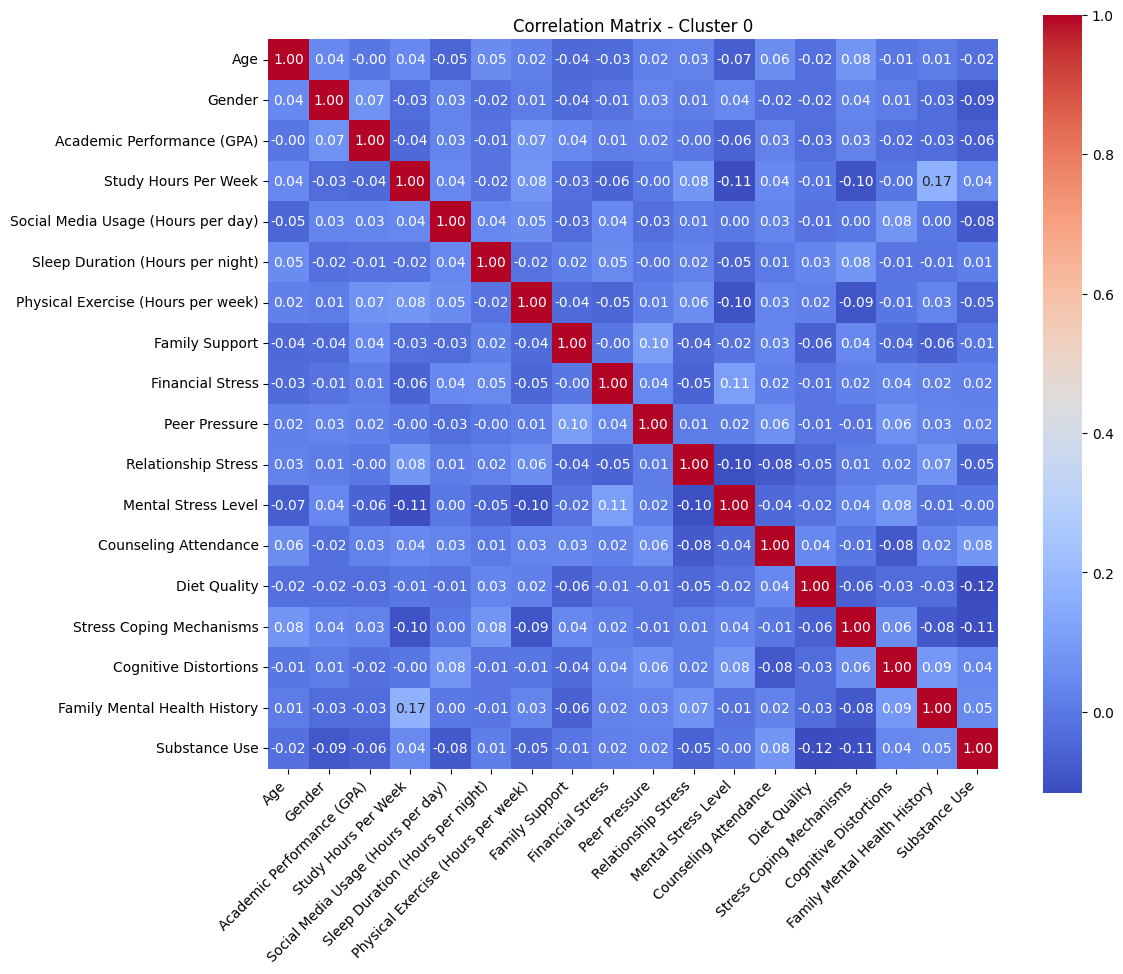


---Cluster Correlation 1 ---


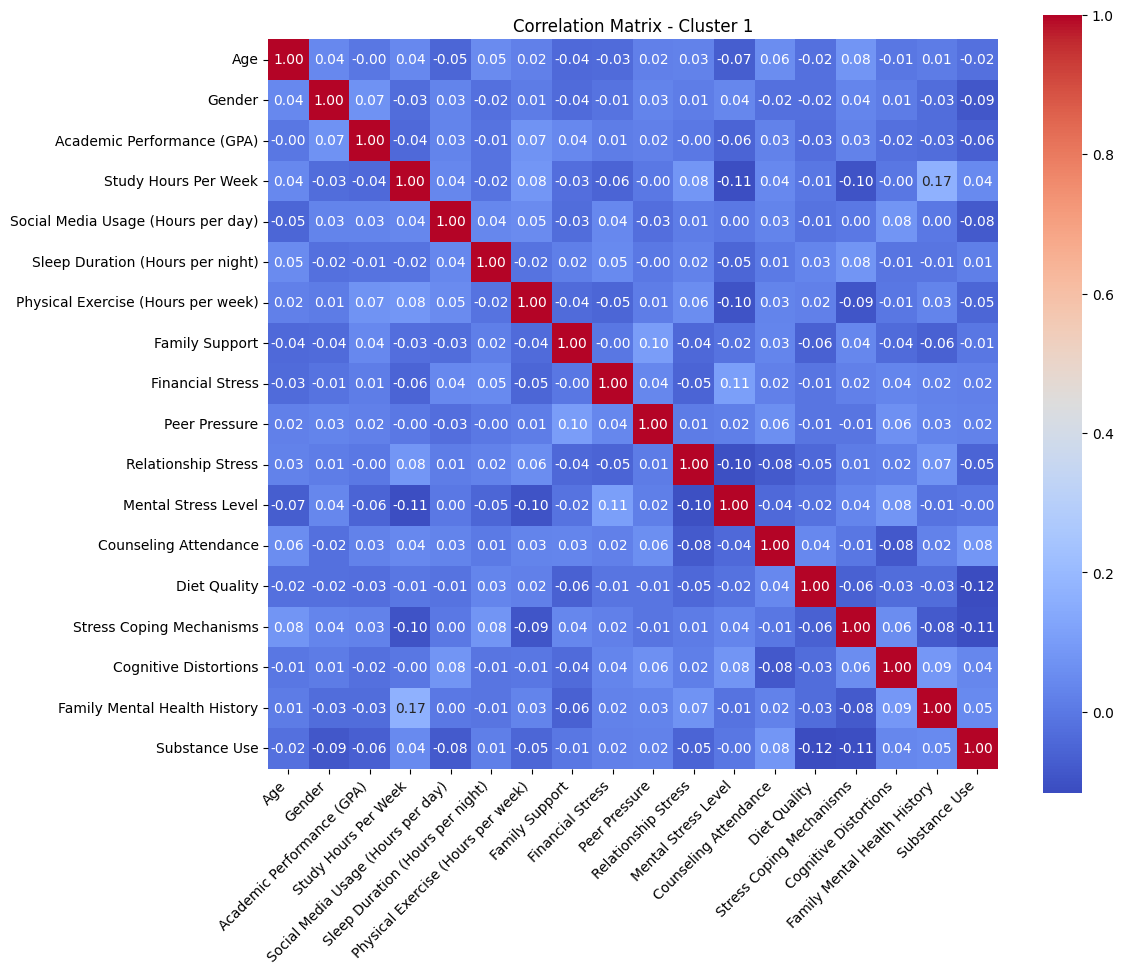

In [391]:
# Correlation
print("-----------------------------------------------------------------------------------------------------------------------------------------------")
print("Correlation matrix :")
print("-----------------------------------------------------------------------------------------------------------------------------------------------\n")

# Correlation matrix for each cluster

pdf = df_clusters.select(df_all.columns + ["cluster"]).toPandas()

print("Colonnes disponibles dans le DataFrame :")
print(pdf.columns)


for cluster in sorted(pdf["cluster"].unique()):
    print(f"\n---Cluster Correlation {cluster} ---")

    # Supprimer les colonnes constantes
    constant_cols = [col for col in sub_df.columns if sub_df[col].nunique() <= 1]
    if constant_cols:
        print(f"Colonnes constantes ignorées : {constant_cols}")
        sub_df = sub_df.drop(columns=constant_cols)

    
    corr = sub_df.corr()
#    print(corr)

    # Heatmap for the clusters
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title(f"Correlation Matrix - Cluster {cluster}")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:


# Liste des colonnes numériques (sans features ni cluster ni vecteurs)
numeric_cols = [f.name for f in df_clusters.schema.fields 
                if str(f.dataType) in ['DoubleType', 'IntegerType'] 
                and f.name not in ['cluster']]




for cluster in cluster_ids:
    print(f"\n--- Cluster Correlation {cluster} ---")

    # Filtrer le cluster
    df_cluster = df_clusters.filter(df_clusters["cluster"] == cluster)

    # Extraire les colonnes numériques en RDD puis vers NumPy
    rdd_values = df_cluster.select(numeric_cols).rdd.map(lambda row: [float(x) for x in row])
    data_matrix = np.array(rdd_values.collect())

    # Si pas assez de données, ignorer
    if data_matrix.shape[0] < 2:
        print(f"Pas assez de données pour le cluster {cluster}")
        continue

    # Calcul de la matrice de corrélation avec numpy
    corr_matrix = np.corrcoef(data_matrix, rowvar=False)

)


In [356]:

#Convert pyspark dataframe to pandas
pdf = df_clusters.select(numeric_cols + ["cluster"]).toPandas()



#Correlation by clusters
for cluster in sorted(pdf["cluster"].unique()):
    if (cluster == 2 or cluster == 4 ):
        print(f"\n---Cluster Correlation {cluster} ---")
        sub_df = pdf[pdf["cluster"] == cluster][numeric_cols]
        
        corr = sub_df.corr()
    #    print(corr)

        # Heatmap for the clusters
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
        plt.title(f"Correlation Matrix - Cluster {cluster}")
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

In [340]:
from itertools import combinations

# Liste des colonnes numériques
numeric_cols = df_all.columns

# Pour chaque cluster
for cluster_id in sorted(df_clusters.select("cluster").distinct().rdd.flatMap(lambda x: x).collect()):
    print(f"\n📊 Correlation matrix for Cluster {cluster_id}:")

    # Filtrer les lignes de ce cluster
    df_cluster = df_clusters.filter(df_clusters["cluster"] == cluster_id)

    # Calculer la corrélation entre chaque paire de colonnes
    for col1, col2 in combinations(numeric_cols, 2):
        corr_value = df_cluster.stat.corr(col1, col2)
        print(f"Corr({col1}, {col2}) = {corr_value:.4f}")



📊 Correlation matrix for Cluster 0:
Corr(Age, Gender) = -0.0919
Corr(Age, Academic Performance (GPA)) = 0.0636
Corr(Age, Study Hours Per Week) = -0.0147
Corr(Age, Social Media Usage (Hours per day)) = -0.0010
Corr(Age, Sleep Duration (Hours per night)) = 0.0333
Corr(Age, Physical Exercise (Hours per week)) = -0.0132
Corr(Age, Family Support) = 0.0623
Corr(Age, Financial Stress) = 0.0373
Corr(Age, Peer Pressure) = 0.0768
Corr(Age, Relationship Stress) = -0.0703
Corr(Age, Mental Stress Level) = -0.0353
Corr(Age, Counseling Attendance) = 0.0569
Corr(Age, Diet Quality) = 0.0468
Corr(Age, Stress Coping Mechanisms) = 0.0370
Corr(Age, Cognitive Distortions) = 0.0126
Corr(Age, Family Mental Health History) = 0.0168


25/07/25 01:23:18 ERROR Executor: Exception in task 0.0 in stage 33372.0 (TID 44610)
org.apache.spark.SparkArithmeticException: [DIVIDE_BY_ZERO] Division by zero. Use `try_divide` to tolerate divisor being 0 and return NULL instead. If necessary set "spark.sql.ansi.enabled" to "false" to bypass this error. SQLSTATE: 22012
== DataFrame ==
"corr" was called from
jdk.internal.reflect.GeneratedMethodAccessor281.invoke(Unknown Source)

	at org.apache.spark.sql.errors.QueryExecutionErrors$.divideByZeroError(QueryExecutionErrors.scala:203)
	at org.apache.spark.sql.errors.QueryExecutionErrors.divideByZeroError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage4.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluator

ArithmeticException: [DIVIDE_BY_ZERO] Division by zero. Use `try_divide` to tolerate divisor being 0 and return NULL instead. If necessary set "spark.sql.ansi.enabled" to "false" to bypass this error. SQLSTATE: 22012
== DataFrame ==
"corr" was called from
jdk.internal.reflect.GeneratedMethodAccessor281.invoke(Unknown Source)


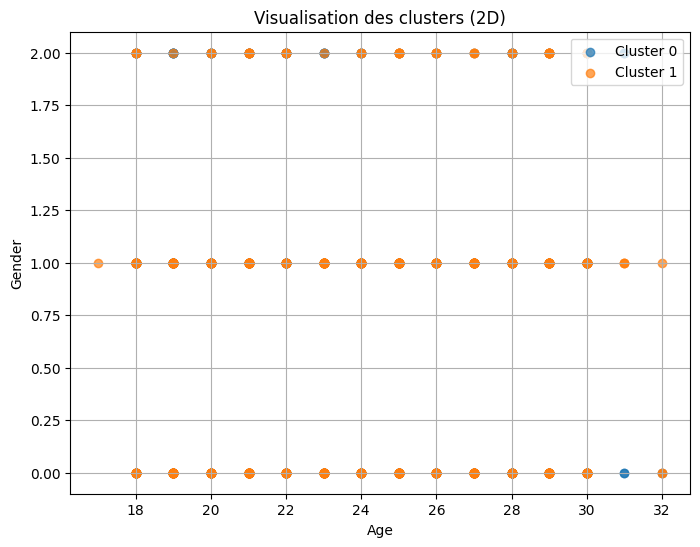

In [341]:
import matplotlib.pyplot as plt

# Sélectionner deux colonnes à projeter (ou les 2 premières colonnes du vecteur)
col_x = numeric_cols[0]
col_y = numeric_cols[1]

# Récupérer les colonnes + cluster dans un DataFrame Pandas uniquement pour tracer
plot_df = df_clusters.select(col_x, col_y, "cluster").toPandas()

# Afficher le scatter plot
plt.figure(figsize=(8, 6))
for cluster_id in sorted(plot_df['cluster'].unique()):
    subset = plot_df[plot_df['cluster'] == cluster_id]
    plt.scatter(subset[col_x], subset[col_y], label=f'Cluster {cluster_id}', alpha=0.7)

plt.xlabel(col_x)
plt.ylabel(col_y)
plt.title("Visualisation des clusters (2D)")
plt.legend()
plt.grid(True)
plt.show()



📊 Correlation matrix for Cluster 0:


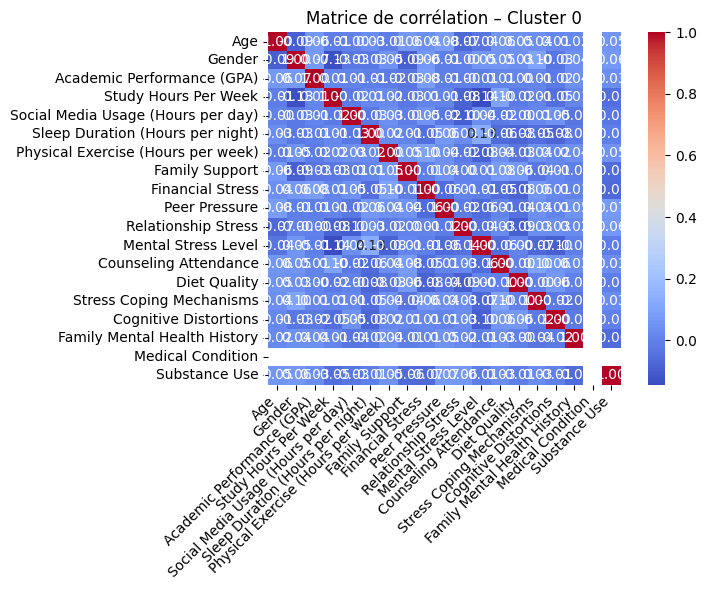


📊 Correlation matrix for Cluster 1:


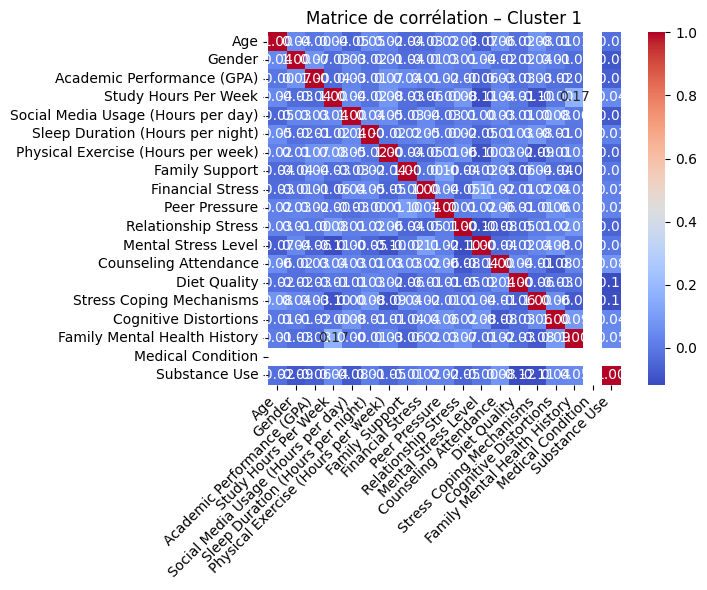

In [342]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des colonnes numériques utilisées pour l’analyse
numeric_cols = df_all.columns

# Pour chaque cluster
cluster_ids = df_clusters.select("cluster").distinct().rdd.flatMap(lambda x: x).collect()

for cluster_id in sorted(cluster_ids):
    print(f"\n📊 Correlation matrix for Cluster {cluster_id}:")

    # Filtrer les lignes de ce cluster
    df_cluster = df_clusters.filter(df_clusters["cluster"] == cluster_id)

    # Convertir en Pandas pour calcul de corrélation complet + heatmap
    df_pandas = df_cluster.select(numeric_cols).toPandas()

    # Calcul de la matrice de corrélation
    corr_matrix = df_pandas.corr(method="pearson")

    # Affichage de la heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title(f"Matrice de corrélation – Cluster {cluster_id}")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
